In [106]:
# -*- coding: utf-8 -*-
# --- Multiome PBMC Trajectory Analysis (Gene & Peak) - INTERSECTED Myeloid/DC Subset ---
# --- Follows structure of tutorial_human_myeloid.py ---
# --- Assumes input is PROCESSED h5mu file ---
# --- Handles differing cell counts between modalities ---

# --- 1. Setup: Import Libraries ---
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import muon as mu
from muon import atac as ac # Muon ATAC module
import os
import warnings

# Import Gene Trajectory functions
import gene_trajectory as gt
from gene_trajectory.add_gene_bin_score import add_gene_bin_score as gt_add_gene_bin_score
from gene_trajectory.coarse_grain import select_top_genes as gt_select_top_genes
from gene_trajectory.coarse_grain import coarse_grain_adata as gt_coarse_grain_adata
from gene_trajectory.extract_gene_trajectory import get_gene_embedding as gt_get_gene_embedding
from gene_trajectory.extract_gene_trajectory import extract_gene_trajectory as gt_extract_gene_trajectory
from gene_trajectory.get_graph_distance import get_graph_distance # Can use the same function
from gene_trajectory.gene_distance_shared import cal_ot_mat as gt_cal_ot_mat
from gene_trajectory.run_dm import run_dm # Can use the same function
from gene_trajectory.plot.gene_trajectory_plots import plot_gene_trajectory_3d as gt_plot_gene_trajectory_3d
from gene_trajectory.plot.gene_trajectory_plots import plot_gene_trajectory_umap as gt_plot_gene_trajectory_umap

# Import Peak Trajectory functions (assuming installed as 'peak_trajectory')
import sys
sys.path.append('/home/chene5/_hd_stats/peak_traj/')  # Adjust this path to where peak_trajectory is located
import peak_trajectory as pt
from peak_trajectory.add_peak_bin_score import add_peak_bin_score as pt_add_peak_bin_score
from peak_trajectory.coarse_grain import select_top_peaks as pt_select_top_peaks
from peak_trajectory.coarse_grain import coarse_grain_adata_peaks as pt_coarse_grain_adata_peaks
from peak_trajectory.extract_peak_trajectory import get_peak_embedding as pt_get_peak_embedding
from peak_trajectory.extract_peak_trajectory import extract_peak_trajectory as pt_extract_peak_trajectory
from peak_trajectory.peak_distance_shared import cal_ot_mat as pt_cal_ot_mat
from peak_trajectory.plot.peak_trajectory_plots import plot_peak_trajectory_3d as pt_plot_peak_trajectory_3d
from peak_trajectory.plot.peak_trajectory_plots import plot_peak_trajectory_umap as pt_plot_peak_trajectory_umap
# get_graph_distance and run_dm can be reused from either package


In [3]:
# Settings
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning) # Add UserWarning ignore
pd.set_option('display.max_columns', 50)

# --- Configuration ---
processed_mudata_path = "/data/peer/chene5/_hd_stats/pbmc10k.h5mu" # <<<=== SET PATH TO YOUR PROCESSED h5mu FILE
target_celltypes = ['CD14 mono', 'intermediate mono', 'mDC', 'CD16 mono']


scanpy==1.10.2 anndata==0.10.8 umap==0.5.6 numpy==1.26.4 scipy==1.13.1 pandas==2.2.2 scikit-learn==1.5.1 statsmodels==0.14.2 igraph==0.11.5 pynndescent==0.5.13


In [4]:
# --- 2. Load PROCESSED Data ---
print(f"Loading processed MuData from: {processed_mudata_path}")
if not os.path.exists(processed_mudata_path):
    raise FileNotFoundError(f"Processed MuData file not found at {processed_mudata_path}")
mdata = mu.read(processed_mudata_path)
print("--- Initial Processed MuData Info ---")
print(mdata)


Loading processed MuData from: /data/peer/chene5/_hd_stats/pbmc10k.h5mu


In [5]:
mdata

MuData object with n_obs × n_vars = 11157 × 132435
  var:	'gene_ids', 'feature_types', 'genome', 'interval', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
  2 modalities
    rna:	10888 x 26349
      obs:	'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'celltype'
      var:	'gene_ids', 'feature_types', 'genome', 'interval', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
      uns:	'celltype_colors', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
      obsm:	'X_pca', 'X_umap'
      varm:	'PCs'
      obsp:	'connectivities', 'distances'
    atac:	9498 x 106086
      obs:	'n_genes_by_counts', 'total_counts', 'NS', 'nucleosome_signal', 'tss_score', 'n_counts', 'leiden', 'celltype'
      var:	'gene_ids', 'feature_types', 'genome', 'interval', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
      uns:	'atac', 'celltype_colors', 'files', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
      obsm:	'X_pca', 'X_umap'
      varm:	'PCs'
      layers:	'counts'
      obsp:	'connectivities', 'distances'

In [6]:
# --- 3. Filter Modalities and Find Common Cells ---
print(f"\n--- Filtering Modalities for Cell Types: {target_celltypes} ---")
# (Code from previous step to filter RNA and ATAC independently, find common_cells,
#  and create rna_int, atac_int - unchanged)

# Filter RNA modality
rna_filt_mask = mdata.mod['rna'].obs['celltype'].isin(target_celltypes)
rna_filt = mdata.mod['rna'][rna_filt_mask].copy()
print(f"Filtered RNA shape: {rna_filt.shape}")
if isinstance(rna_filt.obs['celltype'].dtype, pd.CategoricalDtype):
     rna_filt.obs['celltype'] = rna_filt.obs['celltype'].cat.remove_unused_categories()

# Filter ATAC modality
atac_filt_mask = mdata.mod['atac'].obs['celltype'].isin(target_celltypes)
atac_filt = mdata.mod['atac'][atac_filt_mask].copy()
print(f"Filtered ATAC shape: {atac_filt.shape}")
if isinstance(atac_filt.obs['celltype'].dtype, pd.CategoricalDtype):
     atac_filt.obs['celltype'] = atac_filt.obs['celltype'].cat.remove_unused_categories()

# Find intersection of cells
common_cells = rna_filt.obs_names.intersection(atac_filt.obs_names)
print(f"Found {len(common_cells)} cells present in BOTH filtered RNA and ATAC modalities.")
if len(common_cells) == 0: raise ValueError("No common cells found.")

# Create intersected AnnData objects
rna_int = rna_filt[common_cells,:].copy()
atac_int = atac_filt[common_cells,:].copy()
print("\n--- Intersected AnnData Info ---")
print("RNA (Intersected):", rna_int.shape)
print("ATAC (Intersected):", atac_int.shape)



--- Filtering Modalities for Cell Types: ['CD14 mono', 'intermediate mono', 'mDC', 'CD16 mono'] ---
Filtered RNA shape: (3498, 26349)
Filtered ATAC shape: (3239, 106086)
Found 3093 cells present in BOTH filtered RNA and ATAC modalities.

--- Intersected AnnData Info ---
RNA (Intersected): (3093, 26349)
ATAC (Intersected): (3093, 106086)



--- Visualizing Intersected Cell Types on UMAP ---
Plotting UMAP...


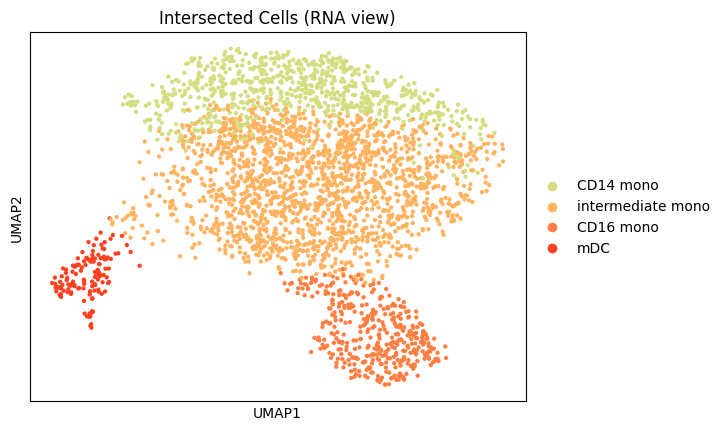

In [7]:
print("\n--- Visualizing Intersected Cell Types on UMAP ---")

# We can use either rna_int or atac_int, let's use rna_int
# Check if UMAP coordinates exist, calculate if necessary
if 'X_umap' not in rna_int.obsm or rna_int.obsm['X_umap'].shape[0] != rna_int.n_obs:
    print("Calculating UMAP for intersected RNA data...")
    # Need PCA first?
    if 'X_pca' not in rna_int.obsm or rna_int.obsm['X_pca'].shape[0] != rna_int.n_obs:
        print("Calculating PCA...")
        # Use normalized data, assuming .X is lognormalized (check this assumption)
        sc.tl.pca(rna_int, svd_solver='arpack')
    # Need Neighbors? (Use PCA)
    if 'neighbors' not in rna_int.uns:
        print("Calculating Neighbors...")
        sc.pp.neighbors(rna_int, n_neighbors=10, n_pcs=30) # Use same params as preprocessing if known
    # Calculate UMAP
    print("Calculating UMAP...")
    sc.tl.umap(rna_int)

# Now plot the UMAP colored by 'celltype'
print("Plotting UMAP...")
sc.pl.umap(rna_int, color=['celltype'], title='Intersected Cells (RNA view)')


ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


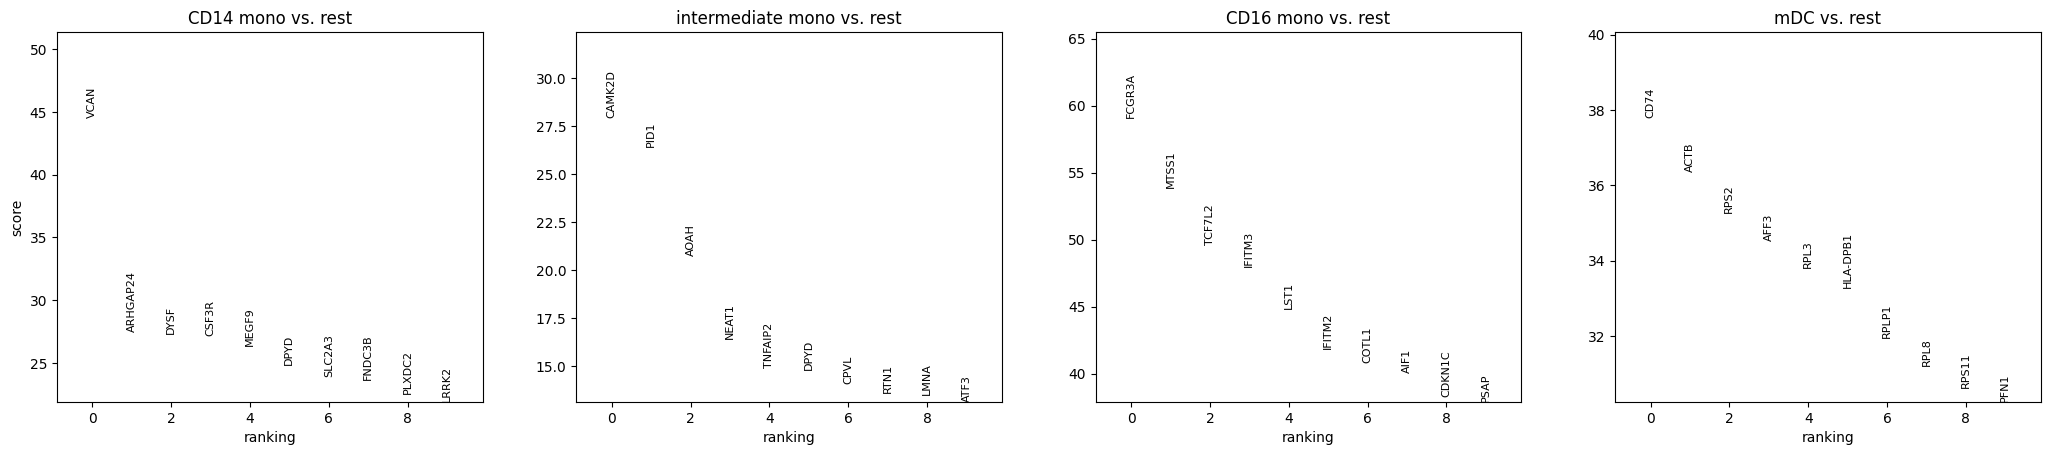

In [27]:
sc.tl.rank_genes_groups(rna_int, 'celltype', method='t-test', n_genes=10)
sc.pl.rank_genes_groups(rna_int, n_genes=10, sharey=False)

Plotting UMAP...


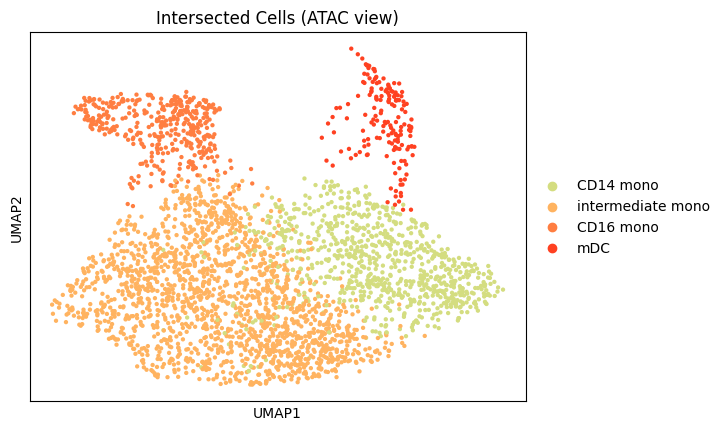

In [8]:
print("Plotting UMAP...")
sc.pl.umap(atac_int, color=['celltype'], title='Intersected Cells (ATAC view)')

In [10]:
# --- 4. Cell Representation and Graph Distance (on Intersection, following tutorial) ---
print("\n--- Computing Cell Diffusion Map and Graph Distance (on Intersected Cells using ATAC PCA) ---")

# Parameters from tutorial_human_myeloid
CELL_DM_K = 10
CELL_DM_N_COMPONENTS = 10 # Adjust if needed, tutorial doesn't specify this directly but uses downstream
GRAPH_DIST_K = 10
GRAPH_DIST_DIMS = 5

# 4.1 Ensure PCA exists on atac_int
if 'X_pca' not in atac_int.obsm or atac_int.obsm['X_pca'].shape[0] != atac_int.n_obs:
     print("Recalculating PCA on intersected ATAC...")
     # Check if scaled data exists, otherwise use lognorm X
     if 'X_scaled' in atac_int.layers: # Hypothetical scaled layer name
         sc.tl.pca(atac_int, use_highly_variable=False, layer='X_scaled', n_comps=30)
     else:
         sc.tl.pca(atac_int, use_highly_variable=False, n_comps=30) # Use lognorm X



--- Computing Cell Diffusion Map and Graph Distance (on Intersected Cells using ATAC PCA) ---


In [13]:
# 4.2 Run Diffusion Map on the intersected cells (atac_int)
print(f"Running Diffusion Map on {atac_int.n_obs} intersected cells...")
# Clear previous results on atac_int if they exist
if 'X_dm_cell' in atac_int.obsm: del atac_int.obsm['X_dm_cell']
if 'neighbors' in atac_int.uns: del atac_int.uns['neighbors'] # Clear neighbors too
if 'connectivities' in atac_int.obsp: del atac_int.obsp['connectivities']
if 'distances' in atac_int.obsp: del atac_int.obsp['distances']

run_dm(
    rna_int,
    reduction="X_pca",
    k=CELL_DM_K,
    n_components=CELL_DM_N_COMPONENTS,
    reduction_result="X_dm_cell"
)

Running Diffusion Map on 3093 intersected cells...


In [14]:
# 4.3 Compute graph distances using the cell DM embedding from atac_int
print(f"Computing cell graph distance using {GRAPH_DIST_DIMS} cell DM dimensions...")
try:
    cell_graph_dist_int = get_graph_distance(
        rna_int,
        reduction='X_dm_cell',
        k=GRAPH_DIST_K,
        dims=GRAPH_DIST_DIMS
    )
    print(f"Intersected cell graph distance matrix shape: {cell_graph_dist_int.shape}")
    assert cell_graph_dist_int.shape[0] == rna_int.n_obs
except Exception as e:
     print(f"Error in graph distance calculation: {e}")
     raise


Computing cell graph distance using 5 cell DM dimensions...
Intersected cell graph distance matrix shape: (3093, 3093)


In [15]:
# 4.4 Copy Cell DM to RNA AnnData for coarse-graining consistency
atac_int.obsm['X_dm_cell'] = rna_int.obsm['X_dm_cell']

In [81]:
# --- 5. Gene Trajectory Analysis (Following tutorial_human_myeloid structure) ---
print("\n--- Running Gene Trajectory Analysis on Intersected Subset---")

# 5.1 Select Top Genes
print("Selecting top genes...")
# Ensure 'counts' layer exists in rna_int
if 'counts' not in rna_int.layers:
     print("Warning: 'counts' layer missing in intersected RNA. Copying from .X")
     rna_int.layers['counts'] = rna_int.raw.X.copy() # Assume X is lognorm, might cause issues with HVG

# Check for NaNs/Infs in the counts layer before HVG
counts_data_rna = rna_int.layers['counts']
if np.any(np.isnan(counts_data_rna.data)) or np.any(np.isinf(counts_data_rna.data)):
     raise ValueError("NaN or Inf values found in RNA 'counts' layer before HVG selection.")

selected_genes = gt_select_top_genes(
    rna_int,
    layer='counts',
    n_variable_genes=500, # Match tutorial
)

print(f"Selected {len(selected_genes)} genes.")
if len(selected_genes) == 0: raise ValueError("No genes selected.")



--- Running Gene Trajectory Analysis on Intersected Subset---
Selecting top genes...
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)
Selected 149 genes.


In [ ]:
#### Use the same top selected genes as tutorial -> Gives similar results!
selected_genes = rna_int.var_names.intersection(['LYPD2',
 'FCGR3A',
 'FCER1A',
 'HLA-DQA1',
 'CDKN1C',
 'MEG3',
 'C1QA',
 'CLEC10A',
 'C1QB',
 'EREG',
 'CD1C',
 'LMNA',
 'G0S2',
 'CCL3',
 'CXCL8',
 'ENHO',
 'RHOC',
 'ARL4C',
 'PPP1R14A',
 'CXCL3',
 'HLA-DQA2',
 'CCL4',
 'IGHM',
 'MT2A',
 'IFITM3',
 'CKB',
 'PTX3',
 'OLFM1',
 'PTGS2',
 'GPR183',
 'IFI6',
 'LY6E',
 'EGR1',
 'VMO1',
 'HES4',
 'APOBEC3A',
 'TCF7L2',
 'RETN',
 'EMP1',
 'PPBP',
 'RECK',
 'IGLC2',
 'IFI30',
 'SCGB3A1',
 'CXCL2',
 'THBS1',
 'RGCC',
 'PLIN5',
 'C12orf75',
 'HES1',
 'MTSS1',
 'SOX4',
 'ID1',
 'IFI44L',
 'RGS1',
 'SOCS3',
 'IFIT3',
 'FPR3',
 'IGHD',
 'VSIG4',
 'TNFAIP6',
 'HIPK1-AS1',
 'NDRG2',
 'PLD4',
 'CHST2',
 'CD79A',
 'ISG15',
 'MARCKSL1',
 'LINC02345',
 'BASP1',
 'HCAR3',
 'PF4',
 'FABP5',
 'CAVIN2',
 'SLC38A1',
 'DUSP2',
 'HIST1H2BG',
 'MX1',
 'TNNT1',
 'CD79B',
 'CES1',
 'FCGR2B',
 'ITM2C',
 'PKIB',
 'ID3',
 'NR4A1',
 'GFRA2',
 'PHACTR1',
 'OSM',
 'IER3',
 'PPM1N',
 'IL1R2',
 'TUBB1',
 'ATP1B1',
 'C1orf54',
 'CYP4F22',
 'AC103591.3',
 'EVL',
 'CD22',
 'ABI3',
 'SCN9A',
 'ALOX5AP',
 'IFIT1',
 'TNFAIP3',
 'KBTBD7',
 'IGKC',
 'CD1E',
 'INSIG1',
 'CTSL',
 'CD9',
 'S100B',
 'DEPTOR',
 'RNASE2',
 'IFIT2',
 'LTB',
 'NEU1',
 'GBP1',
 'HBEGF',
 'DUSP5',
 'ADM',
 'CIITA',
 'TCL1A',
 'AL355075.4',
 'C3AR1',
 'ARL4D',
 'AC245014.3',
 'BCL2A1',
 'KCNQ1OT1',
 'SIGLEC10',
 'SERPINB2',
 'SEMA6B',
 'IL7R',
 'NKG7',
 'HLA-DOA',
 'CDKN1A',
 'GRIP1',
 'BIN1',
 'TNF',
 'F13A1',
 'CLU',
 'TLR10',
 'DDIT4',
 'ADA',
 'PHLDA1',
 'LGMN',
 'CXCL1',
 'RRAS',
 'PHLDA2',
 'HIST1H1C',
 'ALDH1A1',
 'ZNF703',
 'EZR',
 'SLC39A8',
 'CXCR4',
 'SLC16A1-AS1',
 'TSPYL2',
 'FMNL2',
 'GSN',
 'PRMT9',
 'C15orf48',
 'MS4A4A',
 'PTP4A3',
 'ANKRD28',
 'HIST1H2AE',
 'MARCO',
 'NRG1',
 'STEAP4',
 'PID1',
 'FCER2',
 'FAM110A',
 'PAG1',
 'MS4A1',
 'H1F0',
 'MAP3K7CL',
 'AC108134.2',
 'NEURL1',
 'MROH8',
 'SH2D1B',
 'CD2',
 'PDLIM1',
 'AC064805.1',
 'BCL11A',
 'GABPB1-AS1',
 'BCL7A',
 'LKAAEAR1',
 'FGFRL1',
 'SASH1',
 'SLC2A6',
 'TRPM4',
 'ITGB7',
 'HCAR2',
 'RORA',
 'VAMP5',
 'PTMS',
 'GBP4',
 'AHR',
 'ICAM4',
 'PNMA1',
 'TENT5A',
 'AC098818.2',
 'MSR1',
 'L1TD1',
 'PADI4',
 'PPA1',
 'ZBTB20',
 'PPP1R17',
 'ATF3',
 'TCF4',
 'ARRDC4',
 'STAT1',
 'CLEC5A',
 'AC025164.1',
 'SERPINB10',
 'ANKRD22',
 'CACNB4',
 'LOH12CR2',
 'RNF144B',
 'BATF3',
 'AL024507.2',
 'CD72',
 'CCL5',
 'DST',
 'SPATS2L',
 'CHML',
 'BLNK',
 'OLIG1',
 'SERPINF1',
 'CRIP1',
 'LUCAT1',
 'S1PR3',
 'TRIB1',
 'PTGDR2',
 'LILRA4',
 'HSPB1',
 'CD83',
 'PLA2G7',
 'RASD1',
 'FADS1',
 'MGLL',
 'XAF1',
 'ODF2L',
 'OAS1',
 'CLIC2',
 'AFF3',
 'CYP4F3',
 'TMEM176A',
 'DHRS9',
 'BIRC3',
 'CLCN4',
 'ARL4A',
 'FLT3'])

In [ ]:
# Add marker genes we want to include
# selected_genes = np.concatenate([selected_genes, ['CLEC5A', 'CD1C', 'PKIB','VCAN', 'CAMK2D', 'PID1', 'MTSS1', 'CD74', 'ACTB']])

In [89]:
# --- 5.2 Coarse-Graining (Using non-negative data from .raw) ---
print("Coarse-graining intersected RNA data using log-normalized data from .raw...")

# Create a temporary view or copy containing the required genes from .raw
# Ensure selected_genes are present in the raw data's var_names
genes_in_raw = rna_int.raw.var_names.intersection(selected_genes)
if len(genes_in_raw) != len(selected_genes):
    print(f"Warning: Not all selected genes ({len(selected_genes)}) found in rna_int.raw ({len(genes_in_raw)} found). Using intersecting genes.")
    if len(genes_in_raw) == 0:
        raise ValueError("No selected genes found in rna_int.raw. Cannot proceed with coarse graining.")
    # Update selected_genes if you want to proceed with the intersection
    # selected_genes = list(genes_in_raw) # Uncomment if proceeding with intersection is okay

# Extract the log-normalized data for the selected genes from .raw
# Use .to_df() to handle potential sparsity and get a DataFrame, then extract values
try:
    # Accessing .raw might require indexing the original object if .raw wasn't subsetted
    # Assuming rna_int retains the .raw corresponding to its obs_names
    gene_expression_non_negative = rna_int.raw[:, genes_in_raw].X
except Exception as e:
     print(f"Error accessing data from rna_int.raw: {e}")
     print("Ensure rna_int.raw exists and corresponds to the cells in rna_int.")
     raise

# Ensure the extracted data is not sparse for the validation check if needed,
# although coarse_grain might handle sparse input. Let's check min value directly.
min_val_check = gene_expression_non_negative.min()
print(f"Min value in extracted expression data (from .raw): {min_val_check}")
if min_val_check < 0:
    # This shouldn't happen if .raw contains log1p data, but good to check.
    raise ValueError(f"Data extracted from .raw still contains negative values ({min_val_check}). Check preprocessing.")

# Get the cell embedding (this should still come from the main object's obsm)
cell_embedding_cg = rna_int.obsm["X_dm_cell"][:, :GRAPH_DIST_DIMS]

# Call the underlying coarse_grain function directly with the correct expression data
# Note: We bypass gt_coarse_grain_adata to directly provide the correct gene_expression matrix
print("Calling internal coarse_grain function...")
gene_expr_cg, graph_dist_cg_rna = gt.coarse_grain.coarse_grain(
    cell_embedding=cell_embedding_cg,
    gene_expression=gene_expression_non_negative, # Use the non-negative data
    graph_dist=cell_graph_dist_int,
    n=500, # Match tutorial
    random_seed=1 # Match tutorial default if applicable
)

print(f"Coarse-grained gene expr shape: {gene_expr_cg.shape}, graph dist shape: {graph_dist_cg_rna.shape}")


Coarse-graining intersected RNA data using log-normalized data from .raw...
Min value in extracted expression data (from .raw): 0.0
Calling internal coarse_grain function...
Coarse-grained gene expr shape: (500, 251), graph dist shape: (500, 500)


In [92]:
# 5.3 Compute Gene-Gene EMD (on coarse-grained data)
print("Computing gene-gene EMD matrix (on coarse-grained data)...")
gene_emd_mat = gt_cal_ot_mat(
    ot_cost=graph_dist_cg_rna,
    gene_expr=gene_expr_cg,
    show_progress_bar=True,
    processes=os.cpu_count()
)
print(f"Gene EMD matrix shape: {gene_emd_mat.shape}")


Computing gene-gene EMD matrix (on coarse-grained data)...


100%|██████████| 31375/31375 [00:05<00:00, 5651.45it/s]  


Gene EMD matrix shape: (251, 251)


In [93]:
# 5.4 Get Gene Embedding
print("Computing gene embedding...")
# gene_embedding, _ = gt_get_gene_embedding(gene_emd_mat, k=5, n_ev=10)
gene_embedding, _ = gt_get_gene_embedding(gene_emd_mat, k = 5)
print(f"Gene embedding shape: {gene_embedding.shape}")


Computing gene embedding...
Gene embedding shape: (251, 30)


In [94]:
# 5.5 Extract Gene Trajectories
print("Extracting gene trajectories...")
gene_trajectory_df = gt_extract_gene_trajectory(
    gene_embedding=gene_embedding,
    dist_mat=gene_emd_mat,
    gene_names=list(selected_genes),
    t_list=[4, 8, 7], # Match tutorial
    k=5 # Match tutorial
)
print("Gene trajectories extracted:")
print(gene_trajectory_df['selected'].value_counts())


Extracting gene trajectories...
Gene trajectories extracted:
selected
Trajectory-3    169
Trajectory-2     45
Trajectory-1     37
Name: count, dtype: int64


In [95]:
len(gene_trajectory_df.index)

251

In [100]:
temp = gene_trajectory_df['DM_1']
gene_trajectory_df['DM_1'] = gene_trajectory_df['DM_2']
gene_trajectory_df['DM_2'] = temp

Visualizing gene trajectory embedding...


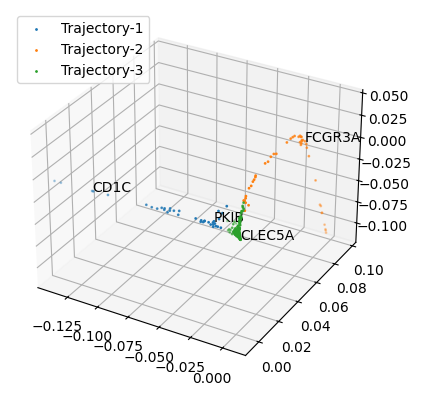

In [ ]:
# 5.6 Visualize Gene Trajectory (3D Embedding)
print("Visualizing gene trajectory embedding...")
#mono_dc_markers = ['CD14', 'FCGR3A', 'CD1C', 'LYZ', 'S100A8', 'S100A9', 'CST3', 'CLEC10A', 'ITGAM', 'VCAN', 'CAMK2D', 'PID1', 'MTSS1', 'CD74', 'ACTB']
mono_dc_markers = ['CLEC5A', 'CD1C', 'PKIB', 'FCGR3A'] # Use the labels used in tutorial
genes_to_label = [g for g in mono_dc_markers if g in gene_trajectory_df.index]
gt_plot_gene_trajectory_3d(gene_trajectory_df, label_genes=genes_to_label)


In [17]:
# # 5.7 Visualize Gene Bin Plots (Optional, requires smoothed/imputed layer)
# # This part remains the same as before, operating on rna_int
# print("Visualizing gene bin plots on UMAP (optional)...")
# rna_plot_layer = 'X_lognorm' # Example, use appropriate layer if available
# if rna_plot_layer == 'alra' and rna_plot_layer not in rna_int.layers:
#     print(f"Layer '{rna_plot_layer}' not found in rna_int. Skipping gene bin UMAP plots.")
# else:
#     if rna_plot_layer == 'X_lognorm':
#          print(f"Using log-normalized data from rna_int.X for UMAP plots.")
#          rna_int.layers[rna_plot_layer] = rna_int.X.copy() # Use .X

#     # Need UMAP coordinates on the intersected cells
#     print("Computing UMAP for intersected RNA data...")
#     # Recalculate PCA/neighbors if needed for rna_int
#     if 'X_pca' not in rna_int.obsm or rna_int.obsm['X_pca'].shape[0] != rna_int.n_obs:
#          sc.tl.pca(rna_int)
#     if 'neighbors' not in rna_int.uns:
#          sc.pp.neighbors(rna_int, use_rep='X_pca')
#     sc.tl.umap(rna_int)

#     gt_add_gene_bin_score(
#         rna_int, # Use intersected data
#         gene_trajectory=gene_trajectory_df,
#         n_bins=5, trajectories=3, layer=rna_plot_layer
#     )
#     if 'Trajectory1_genes1' in rna_int.obs.columns:
#         gt_plot_gene_trajectory_umap(rna_int, 'Trajectory1', other_panels='celltype')
#     # Add plots for Trajectory 2 and 3 if they exist


In [102]:
# --- 6. Peak Trajectory Analysis (Mirroring Gene Trajectory Steps) ---
print("\n--- Running Peak Trajectory Analysis on Intersected Subset ---")

# 6.1 Select Top Peaks (Modified Logic)
print("Selecting top peaks...")

# Ensure 'counts' layer exists for QC filtering (if needed)
if 'counts' not in atac_int.layers:
    print("Warning: 'counts' layer missing in intersected ATAC. Trying to copy from .raw.X")
    if atac_int.raw is not None:
         atac_int.layers['counts'] = atac_int.raw.X.copy() # Prefer raw counts
    else:
         print("Warning: .raw not found. Copying from .X (may not be raw counts)")
         atac_int.layers['counts'] = atac_int.X.copy() # Fallback

# --- Parameters for peak selection ---
counts_layer_peaks = 'counts' # Layer with counts for accessibility calculation
layer_for_hvg = None # Use default atac_int.X (assumed lognormalized) for variability calc
min_accessibility_percent = 0.01
max_accessibility_percent = 0.5
hvg_flavor_peaks = 'seurat' # <<<=== TRY 'seurat' or 'cell_ranger'
n_top_peaks = 1500
hvg_min_mean = 0.01 # Parameter for HVG selection
hvg_max_mean = 2.0  # Parameter for HVG selection
hvg_min_disp = 0.25 # Parameter for HVG selection
# --- End Parameters ---


# 1. Calculate QC metrics based on counts_layer_peaks
print(f"Calculating QC metrics using layer: {counts_layer_peaks}")
sc.pp.calculate_qc_metrics(atac_int, layer=counts_layer_peaks, inplace=True, percent_top=None, log1p=False)

# 2. Filter peaks by accessibility percentage
print("Filtering peaks by accessibility...")
accessibility_percent = atac_int.var['n_cells_by_counts'] / atac_int.n_obs
peak_mask_accessibility = (
    (accessibility_percent > min_accessibility_percent) &
    (accessibility_percent < max_accessibility_percent)
)
current_peak_set = atac_int.var_names[peak_mask_accessibility]
print(f"Peaks after accessibility filtering: {len(current_peak_set)}")

if len(current_peak_set) == 0:
    raise ValueError("No peaks left after accessibility filtering.")

# Create a temporary AnnData view/copy for HVG calculation
adata_filt_peaks = atac_int[:, current_peak_set].copy() # Use copy to avoid modifying atac_int unintentionally here

# 3. Find highly variable peaks using the chosen flavor
print(f"Calculating HVGs using flavor='{hvg_flavor_peaks}' on layer: {'X' if layer_for_hvg is None else layer_for_hvg}")
try:
    sc.pp.highly_variable_genes(
        adata_filt_peaks,
        layer=layer_for_hvg, # Use default X (assumed lognormalized) or specified layer
        n_top_genes=n_top_peaks, # Use n_top_genes param for peaks
        min_mean=hvg_min_mean,
        max_mean=hvg_max_mean,
        min_disp=hvg_min_disp,
        flavor=hvg_flavor_peaks # Use the chosen robust flavor
    )
    hvg_mask_peaks = adata_filt_peaks.var['highly_variable']
    selected_peaks = adata_filt_peaks.var_names[hvg_mask_peaks].tolist()

except Exception as e:
     print(f"Error during HVG calculation for peaks with flavor='{hvg_flavor_peaks}': {e}")
     # You might add checks here about the data in adata_filt_peaks.X if errors persist
     # print(f"Min value in peak matrix for HVG: {adata_filt_peaks.X.min()}")
     raise e


print(f"Selected {len(selected_peaks)} peaks after HVG selection.")
if len(selected_peaks) == 0: raise ValueError("No peaks selected.")


--- Running Peak Trajectory Analysis on Intersected Subset ---
Selecting top peaks...
Calculating QC metrics using layer: counts
Filtering peaks by accessibility...
Peaks after accessibility filtering: 75995
Calculating HVGs using flavor='seurat' on layer: X
extracting highly variable genes


/home/chene5/miniconda3/envs/hd_stats/lib/python3.9/site-packages/scanpy/_utils/__init__.py:551: RuntimeWarning: overflow encountered in multiply
  return x * y
/home/chene5/miniconda3/envs/hd_stats/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:305: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
Selected 1500 peaks after HVG selection.


In [107]:
# --- 6.2 Coarse-Graining (Specify Non-Negative Layer) ---
print("Coarse-graining intersected ATAC data...")

# Choose the layer with non-negative data:
# Option A: Use raw counts if available and appropriate
layer_for_atac_cg = 'counts'
# Option B: Use binarized data (often suitable for ATAC EMD)
# You create this layer later in 6.7, so you might need to create it earlier OR use counts
# layer_for_atac_cg = 'counts_binary'
# if layer_for_atac_cg not in atac_int.layers:
#      print(f"Creating binary layer '{layer_for_atac_cg}' from counts...")
#      if 'counts' not in atac_int.layers:
#          raise ValueError("Cannot create binary layer as 'counts' layer is missing.")
#      atac_int.layers[layer_for_atac_cg] = (atac_int.layers['counts'] > 0).astype(int)


print(f"Using layer '{layer_for_atac_cg}' for coarse graining peak accessibility.")
# Check minimum value in the chosen layer
min_val_check_atac = atac_int[:, selected_peaks].layers[layer_for_atac_cg].min()
print(f"Min value in layer '{layer_for_atac_cg}': {min_val_check_atac}")
if min_val_check_atac < 0:
    raise ValueError(f"Chosen layer '{layer_for_atac_cg}' still contains negative values.")


# Call the function specifying the layer
try:
    peak_acc_cg, graph_dist_cg_atac = pt_coarse_grain_adata_peaks(
        atac_int, # Use intersected ATAC
        graph_dist=cell_graph_dist_int, # Use intersected distance matrix
        features=selected_peaks,
        n=500, # Match tutorial
        reduction="X_dm_cell", # Use cell DM from intersection
        dims=GRAPH_DIST_DIMS,
        layer=layer_for_atac_cg # <<< Specify the non-negative layer
    )
    print(f"Coarse-grained peak accessibility shape: {peak_acc_cg.shape}")
    print(f"Coarse-grained graph distance shape: {graph_dist_cg_atac.shape}")

except ValueError as e:
     print(f"Error during ATAC coarse graining: {e}")
     raise e


Coarse-graining intersected ATAC data...
Using layer 'counts' for coarse graining peak accessibility.
Min value in layer 'counts': 0.0
Coarse-grained peak accessibility shape: (500, 1500)
Coarse-grained graph distance shape: (500, 500)


In [108]:
# 6.3 Compute Peak-Peak EMD (on coarse-grained data)
print("Computing peak-peak EMD matrix (on coarse-grained data)...")
peak_emd_mat = pt_cal_ot_mat(
    ot_cost=graph_dist_cg_atac,
    peak_acc=peak_acc_cg,
    show_progress_bar=True,
    processes=os.cpu_count()
)
print(f"Peak EMD matrix shape: {peak_emd_mat.shape}")

Computing peak-peak EMD matrix (on coarse-grained data)...


100%|██████████| 1124250/1124250 [00:12<00:00, 87206.03it/s] 


Peak EMD matrix shape: (1500, 1500)


In [109]:
# 6.4 Get Peak Embedding
print("Computing peak embedding...")
peak_embedding, _ = pt_get_peak_embedding(peak_emd_mat, k=5)
print(f"Peak embedding shape: {peak_embedding.shape}")


Computing peak embedding...
Peak embedding shape: (1500, 30)


In [110]:
# 6.5 Extract Peak Trajectories
print("Extracting peak trajectories...")
peak_trajectory_df = pt_extract_peak_trajectory(
    peak_embedding=peak_embedding,
    dist_mat=peak_emd_mat,
    peak_names=list(selected_peaks),
    t_list=[4, 8, 7], # Match tutorial
    k=5 # Match tutorial
)
print("Peak trajectories extracted:")
print(peak_trajectory_df['selected'].value_counts())

Extracting peak trajectories...


Early stop reached. No remaining peaks to assign. 2 peak trajectories were retrieved.


Peak trajectories extracted:
selected
Trajectory-1    1495
Trajectory-2       5
Name: count, dtype: int64


Visualizing peak trajectory embedding...


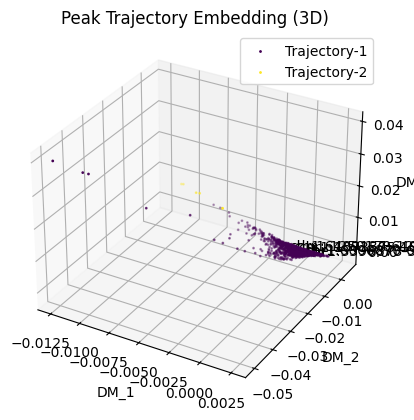

In [112]:
# 6.6 Visualize Peak Trajectory (3D Embedding)
print("Visualizing peak trajectory embedding...")
vis_peaks = peak_trajectory_df.index[:5].tolist()
pt_plot_peak_trajectory_3d(peak_trajectory_df, label_peaks=vis_peaks)


In [ ]:
# # 6.7 Visualize Peak Bin Plots (Optional)
# # This part remains similar, operating on atac_int
# print("Visualizing peak bin plots on UMAP (optional)...")
# plot_layer_atac = 'counts_binary'
# if plot_layer_atac not in atac_int.layers:
#      print(f"Creating binary layer '{plot_layer_atac}' from counts...")
#      atac_int.layers[plot_layer_atac] = (atac_int.layers['counts'] > 0).astype(int)

# # Need UMAP coordinates on the intersected cells
# if 'X_umap' not in atac_int.obsm or atac_int.obsm['X_umap'].shape[0] != atac_int.n_obs:
#      print("Computing UMAP for intersected ATAC data...")
#      if 'neighbors' not in atac_int.uns: # Check if neighbors were computed for DM
#           print("Computing neighbors for intersected ATAC UMAP...")
#           sc.pp.neighbors(atac_int, use_rep='X_pca', n_pcs=GRAPH_DIMS) # Use same params as graph dist neighbor calc
#      sc.tl.umap(atac_int)

# pt_add_peak_bin_score(
#     atac_int, # Use intersected data
#     peak_trajectory=peak_trajectory_df,
#     n_bins=5, trajectories=3, layer=plot_layer_atac
# )
# if 'Trajectory1_peaks1' in atac_int.obs.columns:
#     pt_plot_peak_trajectory_umap(atac_int, 'Trajectory1', other_panels='celltype')
# # Add plots for Trajectory 2 and 3 if they exist


# print("\n--- Analysis Complete ---")